In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
all_dfs = []
for i in [4]:
    print(i)
    df = pd.read_csv('data/'+str(i)+'_mw_disp_full.csv')
    df.columns = ['x', 'y', 'z']
    df['t_ns'] = np.arange(df.shape[0])*0.1/1000
    df['traj'] = i
    all_dfs.append(df)
df = pd.concat(all_dfs)

4


In [6]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import tidynamics as td

In [4]:
df.head()

,x,y,z,t_ns,traj
0,-0.05445,-0.01683,0.01155,0.0000,4
1,-0.04495,-0.05055,0.04928,0.0001,4
2,-0.06222,-0.03196,0.08865,0.0002,4
3,-0.02451,-0.05754,0.06356,0.0003,4
4,-0.00330,-0.01759,-0.00921,0.0004,4


## VACF for 300 - 500 ns portion

In [74]:
traj = df.loc[(df['t_ns']<500) & (df['t_ns'] > 300) , 'x':'t_ns'].values
dt = df.loc[1, 't_ns'] - df.loc[0, 't_ns']


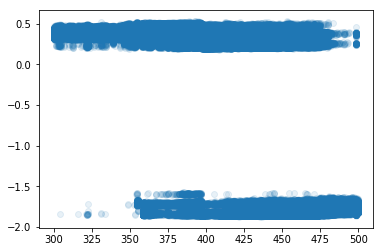

In [81]:
plt.scatter(traj[:, -1], traj[:, 1], alpha=0.1)
# plt.xlim(400, 405)

In [77]:
vtraj = (traj[1:, :]-traj[0:-1,:])
vacf = td.acf(vtraj[:, 0:3])

Text(0,0.5,'v-v acf')

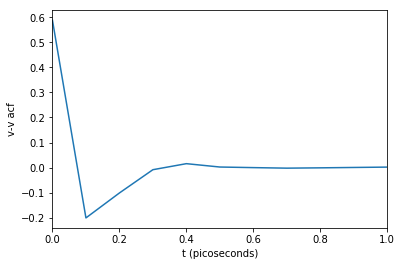

In [78]:
plt.plot(np.arange(traj.shape[0]-1)*0.1, vacf)
plt.xlim(0,1)
plt.xlabel('t (picoseconds)')
plt.ylabel('v-v acf')

Text(0,0.5,'r-r acf')

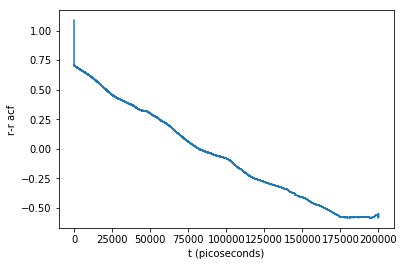

In [79]:
racf = td.acf(traj[:, 0:3])
plt.plot(np.arange(traj.shape[0])/10, racf)
# plt.xlim(0,1)
plt.xlabel('t (picoseconds)')
plt.ylabel('r-r acf')

## Moving window histogram in 300 - 500 ns portion

In [ ]:

window = 2 # window size in ns
skip = 0.5 # skip in ns.  
nrows= int(window/dt)
nskip = int(skip/dt)
starts = np.arange(traj.shape[0])[::nskip]
print(len(starts))

In [ ]:

dr = 0.01 # histogram bin size in nm
ymin = np.min(traj[:,1])
ymax = np.max(traj[:,1])
r_tot = ymax-ymin
nbins = int(r_tot/dr)
bins = np.linspace(ymin, ymax, nbins)
print(nbins)
print(len(bins))

In [ ]:
for i, start in enumerate(starts[:10]):
    print(i, end=', ')
    counts, bins = np.histogram(traj[start:(start+nrows), 1], bins=bins)
    F = -np.log(counts)
    F[np.isinf(F)]=0
    
    plt.plot(bins[:-1], F)
    plt.xlim(ymin, ymax)
    plt.ylim(-10, 0)
    plt.title('{:4.2f}ns'.format(traj[start, -1]))
    plt.savefig('histogram_animation/{:05d}.png'.format(i))
    plt.clf()

In [ ]:
for start in starts: 
    traj = df.iloc[start:start + nrows, 0:3]
    

## Estimate MSM in the region 350 - 450

(array([ 340.,  360.,  380.,  400.,  420.,  440.,  460.]),
 <a list of 7 Text xticklabel objects>)

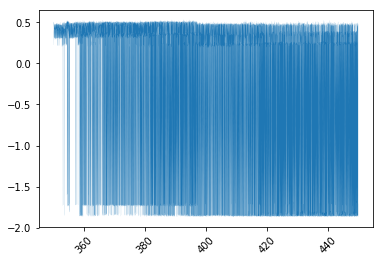

In [88]:
traj = df.loc[(df['t_ns']<450) & (df['t_ns'] > 350) , 'x':'t_ns'].values

plt.plot(traj[:, -1], traj[:,1], lw=0.05, alpha=1)
plt.xticks(rotation=45)


In [115]:

# Cluster
n_clusters = 100 #int(np.sqrt(traj.shape[0]))
clustering = coor.cluster_kmeans(traj[:,0:3],k=n_clusters, max_iter=100)

dtrajs = clustering.dtrajs


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

In [94]:
np.logspace(0, np.log10(1/dt), 10).astype(int)

array([    1,     2,     7,    21,    59,   166,   464,  1291,  3593, 10000])

In [143]:
its = msm.timescales_msm(dtrajs, 
                         np.logspace(0, 5, 100).astype(int), 
                         nits=5, n_jobs=-1)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

(0, 5000)

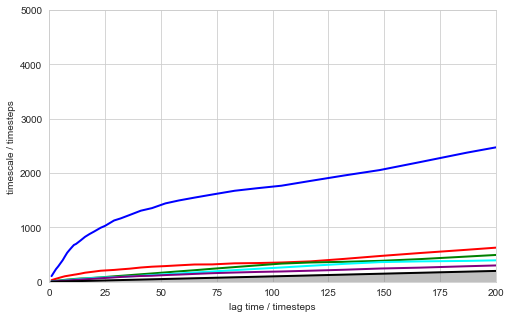

In [151]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, units='timesteps', linewidth=2)
# plt.xscale('log')
plt.xlim(0, 200)
plt.ylim(0, 5000)

In [202]:
M = msm.estimate_markov_model(dtrajs, lag=1)

In [203]:
M.eigenvectors_left().shape

(100, 100)

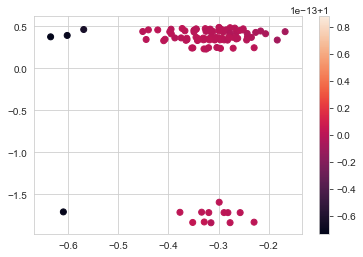

In [205]:
plt.scatter(clustering.clustercenters[:, 0], clustering.clustercenters[:, 1], 
            c=M.eigenvectors_right()[:, 0])
plt.colorbar()

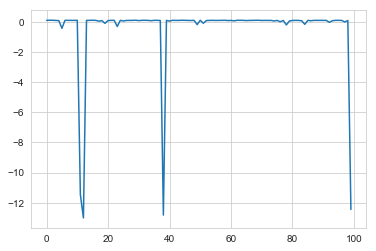

In [198]:
plt.plot(M.eigenvectors_right()[:,1])